In [234]:
import pandas as pd
from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from   scipy.stats import multivariate_normal
import scipy.stats as sp
import matplotlib as mpl
import random

noisy_moons_x , noisy_moons_y =datasets.make_moons(n_samples=500, noise=0.11)
data = {'x':noisy_moons_x[:,0],'y':noisy_moons_x[:,1],'label':noisy_moons_y}
df=pd.DataFrame(data)
df

,x,y,label
0,-0.845112,0.800083,0
1,0.082135,0.295753,1
2,0.553389,-0.449980,1
3,-0.851763,0.428974,0
4,0.047720,0.100272,1
...,...,...,...
495,0.085334,0.087400,1
496,1.304641,-0.398107,1
497,0.218858,-0.082887,1
498,1.940981,0.157713,1


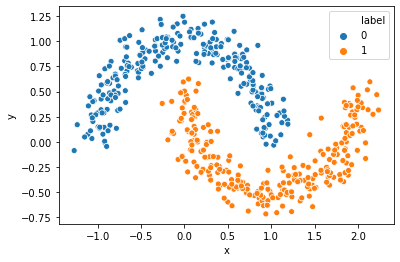

In [235]:
sns.scatterplot(x="x", y="y", hue ='label' ,data=df)

# # part 1

In [208]:
moon_0 = df[df.label==0]
moon_1 = df[df.label==1]
mu_x_0 = sum(moon_0['x'])/moon_0.shape[0]
mu_y_0 = sum(moon_0['y'])/moon_0.shape[0]
mu_x_1 = sum(moon_1['x'])/moon_1.shape[0]
mu_y_1 = sum(moon_1['y'])/moon_1.shape[0]

In [209]:
mu0 = np.ones((250,2))
mu0[:,0] = mu0[:,0]*mu_x_0
mu0[:,1] = mu0[:,1]*mu_y_0
moon_0_array = np.array(moon_0)
xy0 = moon_0_array[:,0:2]
xy_mu0 = xy0 - mu0
cov0 = np.dot(xy_mu0.transpose(),xy_mu0)

mu1 = np.ones((250,2))
mu1[:,0] = mu1[:,0]*mu_x_1
mu1[:,1] = mu1[:,1]*mu_y_1
moon_1_array = np.array(moon_1)
xy1 = moon_1_array[:,0:2]
xy_mu1 = xy1 - mu1
cov1 = np.dot(xy_mu1.transpose(),xy_mu1)

Text(0, 0.5, 'Y')

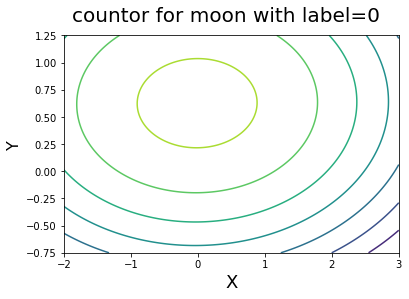

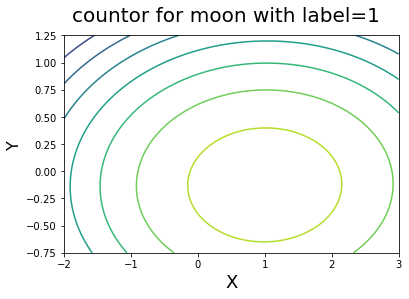

In [210]:
N = 200
X = np.linspace(-2, 3, N)
Y = np.linspace(-0.75, 1.25, N)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))

G0 = multivariate_normal([mu_x_0, mu_y_0], cov0)
Z0 = G0.pdf(pos)
fig = plt.figure()
plt.contour(X, Y, Z0)
fig.suptitle('countor for moon with label=0', fontsize=20)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=16)


G1 = multivariate_normal([mu_x_1, mu_y_1], cov1)
Z1 = G1.pdf(pos)
fig = plt.figure()
plt.contour(X, Y, Z1)
fig.suptitle('countor for moon with label=1', fontsize=20)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=16)

# # part 2 without library

In [236]:
class GaussianMixModel(object):
    def __init__(self, X, k=2):
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        print (np.mean(X))
        # number of mixtures
        self.k = k

    def _init(self):
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n))+np.mean(self.data))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.Z = np.asmatrix(np.empty((self.m, self.k), dtype=float))

    def fit(self, tol=1e-1):
        self._init()
        num_iters = 0
        logl = 1
        previous_logl = 0
        while(logl-previous_logl > tol):
            previous_logl = self.loglikelihood()
            self.e_step()
            self.m_step()
            num_iters += 1
            logl = self.loglikelihood()
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, logl))
        
    def loglikelihood(self):
        logl = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                tmp += sp.multivariate_normal.pdf(self.data[i, :],self.mean_arr[j, :].A1,self.sigma_arr[j, :]) * self.phi[j]
            logl += np.log(tmp)
        return logl

    def e_step(self):
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.multivariate_normal.pdf(self.data[i, :],
                                                       self.mean_arr[j].A1,
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num
                self.Z[i, j] = num
            self.Z[i, :] /= den
            assert self.Z[i, :].sum() - 1 < 1e-4

    def m_step(self):
        for j in range(self.k):
            const = self.Z[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.Z[i, j])
                _sigma_j += self.Z[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const

In [237]:
def make_ellipses(gmm, ax):
    for n in range(gmm.sigma_arr.shape[0]):
        covariances = gmm.sigma_arr[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi 
        v = 3. * np.sqrt(2.) * np.sqrt(v)
        mean=gmm.mean_arr[n]
        mean=mean.reshape(2,1)
        ell = mpl.patches.Ellipse(mean, v[0], v[1],180 + angle ,
                                  color=[random.uniform(0, 1),random.uniform(0, 1),random.uniform(0, 1)])
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

In [238]:
def plot_2D(gmm,x,col,label):
    h = plt.subplot(111, aspect='equal')
    make_ellipses(gmm, h)
    plt.scatter(x[:,0],x[:,1],c=label['label'],marker='x')
    plt.xlim(-2, 3)
    plt.ylim(-1, 1.5)
    plt.xlabel(col[0])
    plt.ylabel(col[1])
    plt.show()

In [239]:
label=df[['label']]
col=['x','y']
x=df[col]
x=np.array(x)


0.37216932502096506
Terminate at 49-th iteration:log-likelihood is -775.285450


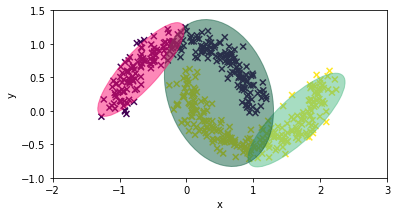

In [240]:
gmm = GaussianMixModel(x,3)
gmm.fit()
plot_2D(gmm,x,col,label)

0.37216932502096506
Terminate at 97-th iteration:log-likelihood is -579.367986


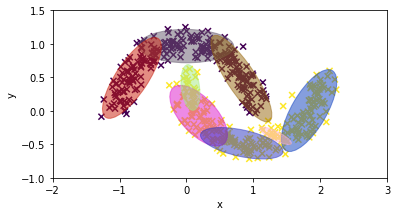

In [241]:
gmm = GaussianMixModel(x,8)
gmm.fit()
plot_2D(gmm,x,col,label)

0.37216932502096506
Terminate at 125-th iteration:log-likelihood is -509.196405


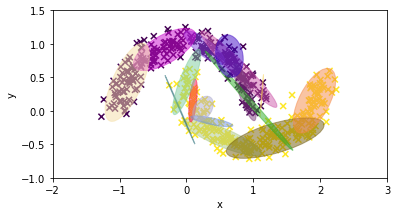

In [242]:
gmm = GaussianMixModel(x,16)
gmm.fit()
plot_2D(gmm,x,col,label)

# # with library

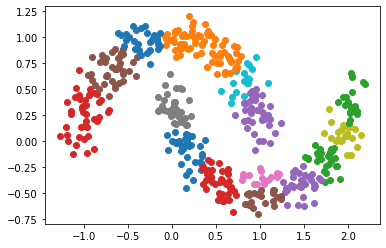

In [3]:

from numpy import unique
from numpy import where
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot

model = GaussianMixture(n_components=16)
model.fit(noisy_moons_x,noisy_moons_y)
yhat = model.predict(noisy_moons_x)
clusters = unique(yhat)
for cluster in clusters:
    row_ix = where(yhat == cluster)
    pyplot.scatter(noisy_moons_x[row_ix, 0], noisy_moons_x[row_ix, 1])
pyplot.show()

# # part 3

In [247]:
from sklearn.mixture import GaussianMixture

label=df[['label']]
col=['x','y']
x=df[col]
x=np.array(x)
x = noisy_moons_x
components = np.arange(1, 10, 1)
models = [GaussianMixture(n) for n in components]
aic = [model.fit(x).aic(x) for model in models]
bic = [model.fit(x).bic(x) for model in models]
plt.plot(components, aic);
plt.plot(components, bic);

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
best_componant = 1
best_aic = float('inf')
for i in range(len(aic)):
    if aic[i]<best_aic:
        best_aic = aic[i]
        best_componant = i*10+10
        
print('best number of componant based on AIC = ',best_componant)


In [ ]:
best_componant = 1
best_bic = float('inf')
for i in range(len(bic)):
    if aic[i]<best_bic:
        best_bic = aic[i]
        best_componant = i*10+10
        
print('best number of componant based on BIC = ',best_componant)
